# Big Data Intelligence: Methods and Technologies

# Assignment 3: Predicting Solar Energy Production
## Authors:  Liana Mehrabyan and Elsa Scola Martín
### Objective:
Given a dataset from the Kaggle competition ”[AMS 2013-2014 Solar Energy Prediction Contest](https://www.kaggle.com/c/ams-2014-solar-energy-prediction-contest/)” the goal of this assignment is to use  meteorological  variables  forecasted  by GFS as input  attributes  to  a machine learning model that is able to estimate how much solar energy is going to be produced at one of the solar plants in Oklahoma.

To solve this problem we focus in applying Pipelines among other techniques seen in class.

### What is done in the Notebook: 
- Load the data and generate artificial missing values.
- Split the train data in train and validation.
- Perform a Decision Trees Pipeline.
- Perform a KNN Pipeline.
- Evaluate the results.
- Decision Trees with Best Parameters on 300 features.
- Choosing k best parameters from 300 features.
- Perform Random Forest and Gradient Boosting on 75 features.

In [142]:
import pandas as pd
from sklearn import preprocessing, tree, metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score, KFold,RandomizedSearchCV, PredefinedSplit
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from scipy.stats import sem 
from numpy.random import randint
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif, f_regression
import xgboost as xgb

## Data Loading and Artificial Missing Value Generation 

In [2]:
train = pd.read_pickle('trainst1ns16.pkl')
test = pd.read_pickle('testst1ns16.pkl')

my_NIA = 100416083
np.random.seed(my_NIA)

how_many_nas = round(train.shape[0]*train.shape[1]*0.05)
print('Lets put '+str(how_many_nas)+' missing values in the train set\n')
x_locations = randint(0, train.shape[0],size=how_many_nas)
y_locations = randint(0, train.shape[1]-1,size=how_many_nas)
for i in range(len(x_locations)):
    train.iloc[x_locations[i], y_locations[i]] = np.nan

how_many_nas = round(test.shape[0]*test.shape[1]*0.05)
print('Lets put '+str(how_many_nas)+' missing values in the test set\n')
x_locations = randint(0, test.shape[0],size=how_many_nas)
y_locations = randint(0, test.shape[1]-1,size=how_many_nas)
for i in range(len(x_locations)):
    test.iloc[x_locations[i], y_locations[i]] = np.nan

    
pd.to_pickle(train, "trainst1ns16_with_nas.pkl")
pd.to_pickle(test, "testst1ns16_with_nas.pkl")

Lets put 263019 missing values in the train set

Lets put 44017 missing values in the test set



In [68]:
train = pd.read_pickle("trainst1ns16_with_nas.pkl")
test = pd.read_pickle("testst1ns16_with_nas.pkl")

## Train/Validation Split 

In [69]:
X_train = train.iloc[:,:75].values
y_train = train.energy.values
X_test = test.iloc[:,:75].values
y_test = test.energy.values

In [70]:
validation_indices = np.zeros(train.shape[0])
# Ten years for training, 2 years for validation
validation_indices[:(10*365)] = -1
tr_val_partition = PredefinedSplit(validation_indices)

# Decision Trees Pipeline

In [72]:

param_grid = {  'imputation__strategy': list(['mean','median']),
              'tree__min_samples_split': list(range(2,36,2))
              
}

clf = Pipeline([
        ('imputation',SimpleImputer()) ,
  ('tree',tree.DecisionTreeRegressor())
])


np.random.seed(0)
clf_DT = GridSearchCV(clf, 
                        param_grid,
                        scoring='neg_mean_absolute_error',
                        cv= tr_val_partition, n_jobs=1, verbose=1)

clf_DT.fit(X_train,y_train)


print(clf_DT.best_params_, clf_DT.best_score_)
y_test_pred = clf_DT.predict(X_test)
print(metrics.mean_absolute_error(y_test, y_test_pred))
mae_DT = metrics.mean_absolute_error(y_test, y_test_pred)

Fitting 1 folds for each of 34 candidates, totalling 34 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    9.9s finished


{'imputation__strategy': 'median', 'tree__min_samples_split': 32} -2693497.163258915
2742625.990874382


# KNN Pipeline

In [74]:
param_grid = {'KNN__n_neighbors': list(range(2,26,2)),
              'imputation__strategy': list(['mean','median'])}


clf = Pipeline([
        ('imputation',SimpleImputer()) ,
  ('normalization', MinMaxScaler()),
  ('KNN', KNeighborsRegressor())
])


np.random.seed(0)
clf_KNN = GridSearchCV(clf, 
                        param_grid,
                        scoring='neg_mean_absolute_error',
                        cv= tr_val_partition, n_jobs=1, verbose=1)

clf_KNN.fit(X_train,y_train)


print(clf_KNN.best_params_, clf_KNN.best_score_)
y_test_pred = clf_KNN.predict(X_test)
print (metrics.median_absolute_error(y_test, y_test_pred))
mae_KNN = metrics.mean_absolute_error(y_test, y_test_pred)

Fitting 1 folds for each of 24 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    6.7s finished


{'KNN__n_neighbors': 24, 'imputation__strategy': 'mean'} -2376984.656849315
1703775.0


## Results

Text(0.5, 1.0, 'MAE: KNN vs Decision Trees')

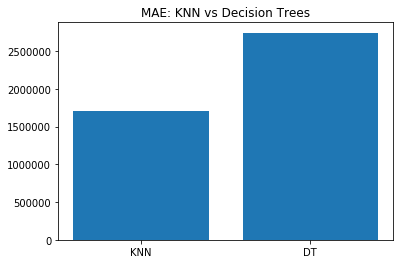

In [165]:
plt.bar(height=[mae_KNN, mae_DT],x=['KNN','DT'])
plt.title('MAE: KNN vs Decision Trees')

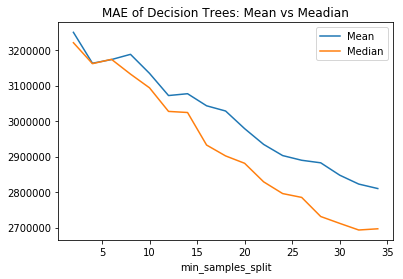

In [76]:
plt.plot(list(range(2,36,2)),np.abs(clf_DT.cv_results_['mean_test_score'][:17]))
plt.plot(list(range(2,36,2)),np.abs(clf_DT.cv_results_['mean_test_score'][17:]))
plt.xlabel('min_samples_split')
plt.title('MAE of Decision Trees: Mean vs Meadian')
plt.legend(['Mean','Median'])

Text(0.5, 1.0, 'MAE of KNN: Mean vs Meadian')

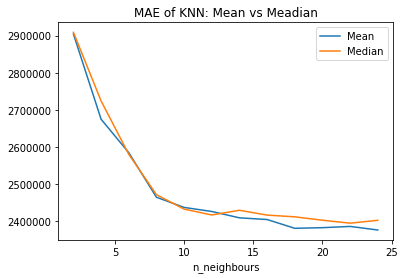

In [89]:
plt.plot(list(range(2,26,2)),np.abs(clf_KNN.cv_results_['mean_test_score'][list(range(0,24,2))]))
plt.plot(list(range(2,26,2)), np.abs(clf_KNN.cv_results_['mean_test_score'][list(range(1,25,2))]))
plt.xlabel('n_neighbours')
plt.legend(['Mean','Median'])
plt.title('MAE of KNN: Mean vs Meadian')

Based on the visualizations above, the imputation method we choose in further steps is imputation by median. This is done for the following reasons: 
- We will be using Decision Trees in further steps, and imputation by median was reported to yield the best score. Moreover the score gap between mean and median imputation is quite significant, although both of them have the same trend. 
- Even though hyperparameter tuning for KNN reported mean imputation to yield the best score, as seen in the figure, this difference is not as big as that of Decision Trees. In addition, even if we were to use KNN in further steps, trusting the elbow method, we would choose n_neighbours = 10 where this difference is even smaller. Hence, choosing mean over median woudln't be a significant improvement either. 

# 300 variables

In [166]:
X_train = train.iloc[:,:300].values
y_train = train.energy.values
X_test = test.iloc[:,:300].values
y_test = test.energy.values

# Saving data imputed with the best methond



In [167]:
imputer = SimpleImputer(strategy ='median') 
# Fitting the data to the imputer object 
#imputer = imputer.fit(X_train)  
# Imputing the data      
X_train = imputer.fit_transform(X_train) 
  
# Fitting the data to the imputer object 
#imputer = imputer.fit(X_test)  
# Imputing the data      
X_test = imputer.transform(X_test)

## Decision Trees with Best Parameters on 300 features

In [168]:
clf = DecisionTreeClassifier(random_state=0, min_samples_split=32)
clf.fit(X=X_train, y=y_train)
y_pred = clf.predict(X_test)
mean_absolute_error(y_test, y_pred)
mae_DT300=mean_absolute_error(y_test, y_pred)

In [177]:
y_pred_train=clf.predict(X_train)
print('MAE Test:',mean_absolute_error(y_pred_train,y_train))
print('MAE_Train:', mae_DT300)

MAE Test: 5608680.383561644
MAE_Train: 6802406.63574352


Text(0.5, 1.0, 'MAE of Decision Trees')

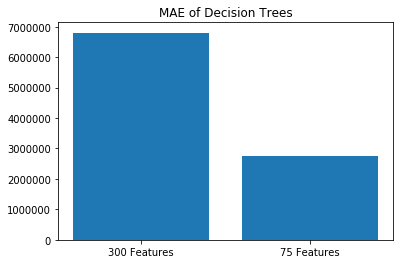

In [114]:
plt.bar(height=[mae_DT300, mae_DT],x=['300 Features','75 Features'])
plt.title('MAE of Decision Trees')

As seen in the figure above, expanding feature set to 300 features did not improve MAE. Moreover, the difference between train and test errors is big (MAE_train>>MAE_test), hence, this model could be overfitting .

### Choosing k best attributes

In [120]:

param_grid = {'feature_selection__k': np.arange(X_train.shape[1])+1,
             'regression__min_samples_split': list(range(2,36,2))}

clf = Pipeline([
  ('feature_selection', SelectKBest(f_regression)),
  ('regression', tree.DecisionTreeRegressor(random_state=0))
])


np.random.seed(0)
clf_grid = GridSearchCV(clf, 
                        param_grid,
                        scoring='neg_mean_absolute_error',
                        cv= tr_val_partition, n_jobs=4, verbose=1)
%time _ = clf_grid.fit(X_train,y_train)


print(clf_grid.best_params_, clf_grid.best_score_)
y_test_pred = clf_grid.predict(X_test)
print(metrics.mean_absolute_error(y_test, y_test_pred))
mae_kbest=metrics.mean_absolute_error(y_test, y_test_pred)

Fitting 1 folds for each of 1275 candidates, totalling 1275 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 617 tasks      | elapsed:   23.7s
[Parallel(n_jobs=4)]: Done 1227 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1275 out of 1275 | elapsed:  1.2min finished


CPU times: user 2.27 s, sys: 308 ms, total: 2.57 s
Wall time: 1min 14s
{'feature_selection__k': 72, 'regression__min_samples_split': 34} -2636535.349388781
2821883.523774294


Text(0.5, 1.0, 'MAE of Decision Trees')

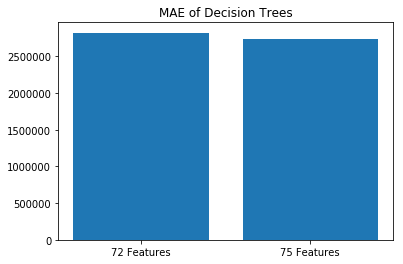

In [121]:
plt.bar(height=[mae_kbest, mae_DT],x=['72 Features','75 Features'])
plt.title('MAE of Decision Trees')

In [124]:

param_grid = {'feature_selection__k': np.arange(X_train.shape[1])+1,
             'regression__min_samples_split': list(range(2,36,2))}

clf = Pipeline([
  ('feature_selection', SelectKBest(f_regression)),
  ('regression', tree.DecisionTreeRegressor(random_state=0))
])


np.random.seed(0)
clf_grid = GridSearchCV(clf, 
                        param_grid,
                        scoring='neg_mean_absolute_error',
                        cv= tr_val_partition, n_jobs=4, verbose=1)
%time _ = clf_grid.fit(X_train,y_train)


print(clf_grid.best_params_, clf_grid.best_score_)
y_test_pred = clf_grid.predict(X_test)
print(metrics.mean_absolute_error(y_test, y_test_pred))
mae_kbest300=metrics.mean_absolute_error(y_test, y_test_pred)

Fitting 1 folds for each of 5100 candidates, totalling 5100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  62 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 362 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done 862 tasks      | elapsed:   45.8s
[Parallel(n_jobs=4)]: Done 1388 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 1838 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 2388 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done 3038 tasks      | elapsed:  7.4min
[Parallel(n_jobs=4)]: Done 3788 tasks      | elapsed: 11.1min
[Parallel(n_jobs=4)]: Done 4638 tasks      | elapsed: 16.1min
[Parallel(n_jobs=4)]: Done 5100 out of 5100 | elapsed: 19.1min finished


CPU times: user 12.7 s, sys: 1.7 s, total: 14.4 s
Wall time: 19min 5s
{'feature_selection__k': 208, 'regression__min_samples_split': 32} -2673319.7717544436
2787856.5050531235


Text(0.5, 1.0, 'MAE of Decision Trees')

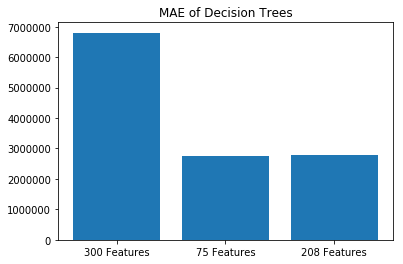

In [178]:
plt.bar(height=[mae_DT300, mae_DT, mae_kbest300],x=['300 Features','75 Features', '208 Features'])
plt.title('MAE of Decision Trees')

Choosing k best parameters from 300 features resulted in 208 best. This however, did not improve the score obtained by first 75 features. Hence, we can conclude that 1 point (i.e 75 features) is enough to obtain best results.  

# Random Forest and GB

We hence go back to first 75 features only. 

In [129]:
X_train = X_train[:,:75]
y_train = train.energy.values
X_test = X_test[:,:75]
y_test = test.energy.values

### RF

In [148]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 100, num = 5)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 5)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]
             }
np.random.seed(0)
clf = GridSearchCV(RandomForestRegressor(), 
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=tr_val_partition, 
                         n_jobs=4, verbose=1
                        )

clf.fit(X=X_train, y=y_train)
y_test_pred = clf.predict(X_test)
print(metrics.mean_absolute_error(y_test, y_test_pred))
clf.best_params_, -clf.best_score_
mae_RF=metrics.mean_absolute_error(y_test, y_test_pred)

Fitting 1 folds for each of 450 candidates, totalling 450 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  9.1min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 20.7min
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed: 20.8min finished


2122663.2704262272


({'max_depth': 35,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 100},
 9932563953705.088)

Text(0.5, 1.0, 'MAE of Decision Trees vs RF')

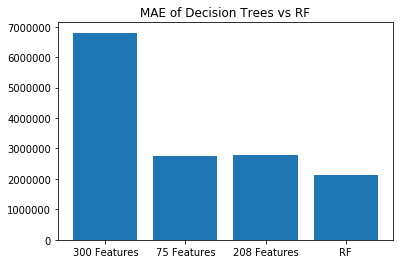

In [181]:
plt.bar(height=[mae_DT300, mae_DT, mae_kbest300,mae_RF],x=['300 Features','75 Features', '208 Features','RF'])
plt.title('MAE of Decision Trees vs RF')

### GB

In [ ]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 100, num = 5)],
               'max_depth': [int(x) for x in np.linspace(5, 110, num = 5)],
               'min_samples_split': [2, 5, 10],
              'learning_rate': [0.07,0.1,0.5,0.7]
             }
np.random.seed(0)
clf = GridSearchCV(GradientBoostingRegressor(), 
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=tr_val_partition, 
                         n_jobs=4, verbose=1
                        )

clf.fit(X=X_train, y=y_train)
y_test_pred = clf.predict(X_test)
print(metrics.mean_absolute_error(y_test, y_test_pred))
clf.best_params_, -clf.best_score_
mae_GB=metrics.mean_absolute_error(y_test, y_test_pred)

## XGBoost


In [158]:
clf = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,                                                                  
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 


clf.fit(X=X_train, y=y_train)
y_test_pred = clf.predict(X_test)
print(metrics.mean_absolute_error(y_test, y_test_pred))
mae_XGB=metrics.mean_absolute_error(y_test, y_test_pred)

[22:04:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2073997.8339017734


Text(0.5, 1.0, 'MAE of Decision Trees vs Ensemble Methods')

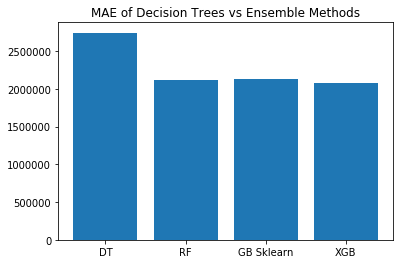

In [183]:
plt.bar(height=[mae_DT, mae_RF, mae_GB,  mae_XGB],x=['DT', 'RF','GB Sklearn','XGB'])
plt.title('MAE of Decision Trees vs Ensemble Methods')

In [184]:
print(mae_XGB)

2073997.8339017734


Ensemble methods were indeed able to improve results. While sklearn gradient boosting implementation performed relatively equal to random forests, xgboost overperformed all the methods tried out. 
Hence, the best method in the scope of these experements is: 

- XGBoost advanced gradient boosting method fit on data that were imputed using their median. 
- The best MAE achieved: 2073997.83